In [2]:
import os
from pathlib import Path
import pandas as pd
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import defaultdict
import itertools
plt.style.use('seaborn-white')

while Path.cwd().name != 'cartography':
    %cd ..

/gscratch/xlab/alisaliu/cartography


In [3]:
from cartography.selection.selection_utils import read_training_dynamics

HOME_DIR = Path('/gscratch/xlab/alisaliu/cartography')

In [4]:
model_dir = HOME_DIR / 'output/mnli'
train_dy_filename = os.path.join(model_dir, "training_td_metrics.jsonl")
train_dy_metrics = pd.read_json(train_dy_filename, lines=True)

In [5]:
train_dy_metrics

,guid,index,threshold_closeness,confidence,final_confidence,variability,mean_variability,correctness,forgetfulness
0,2508243,0,0.100562,0.886572,0.999366,0.223197,0.148798,5,0
1,217363,1,0.098526,0.889196,0.999154,0.218067,0.145378,5,0
2,3258753,2,0.098108,0.889733,0.999597,0.219679,0.146453,5,0
3,994163,3,0.130147,0.846197,0.990470,0.264224,0.176462,4,0
4,2069753,4,0.154585,0.808893,0.968389,0.294134,0.196399,4,0
...,...,...,...,...,...,...,...,...,...
392697,1752363,392697,0.018022,0.981641,0.990454,0.007897,0.005266,5,0
392698,2324073,392698,0.001338,0.998660,0.998982,0.000771,0.000515,5,0
392699,2243013,392699,0.005448,0.994522,0.999756,0.008542,0.005698,5,0
392700,732223,392700,0.006868,0.993084,0.995483,0.001715,0.001201,5,0


## compare different metrics

0.9874984543257269
-0.34241858056195523


<Figure size 432x288 with 0 Axes>

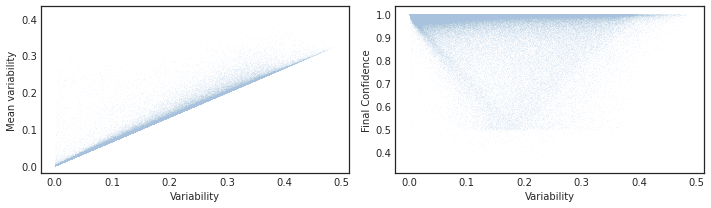

In [10]:
plt.figure()
fig, axes = plt.subplots(1,2,figsize=(10,3))
df = train_dy_metrics#.sample(n=25000)

ax = axes[0]
x = 'variability'
y = 'mean_variability'
sns.scatterplot(x=x, y=y, data=df, s=1, alpha=0.03, ax=ax)
ax.set_xlabel('Variability')
ax.set_ylabel('Mean variability')
print(df[x].corr(df[y]))

ax = axes[1]
x = 'variability'
y = 'final_confidence'
sns.scatterplot(x=x, y=y, data=df, s=1, alpha=0.03, ax=ax)
ax.set_xlabel('Variability')
ax.set_ylabel('Final Confidence')
print(df[x].corr(df[y]))

plt.tight_layout()
plt.savefig('figures/variability_scatterplots.png', dpi=2000)

0.5894286794148259

<Figure size 432x288 with 0 Axes>

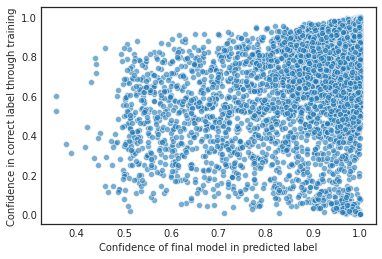

In [81]:
plt.figure()
fig, ax = plt.subplots()
x = 'last_label_confidence'
y = 'confidence'
sns.scatterplot(x=x, y=y, data=df, alpha=0.6)
ax.set_ylabel('Confidence in correct label through training')
ax.set_xlabel('Confidence of final model in predicted label')
df[x].corr(df[y])

0.7644217655152301

<Figure size 432x288 with 0 Axes>

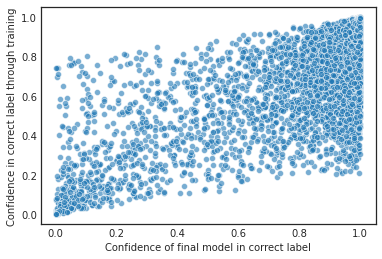

In [82]:
plt.figure()
fig, ax = plt.subplots()
x = 'last_confidence'
y = 'confidence'
sns.scatterplot(x=x, y=y, data=df, alpha=0.6)
ax.set_ylabel('Confidence in correct label through training')
ax.set_xlabel('Confidence of final model in correct label')
df[x].corr(df[y])

## compare models

In [92]:
models = {
    'seed_18': {
        'model_dir': HOME_DIR / 'output/mnli_seed_18'
    },
    'seed_20': {
        'model_dir': HOME_DIR / 'output/mnli_seed_20'
    }
}

In [99]:
train_dy_filename = os.path.join(models['seed_18']['model_dir'], "td_metrics.jsonl")
train_dy_metrics18 = pd.read_json(train_dy_filename, lines=True)
train_dy_metrics18 = train_dy_metrics18.drop('index', axis=1)
train_dy_filename = os.path.join(models['seed_20']['model_dir'], "td_metrics.jsonl")
train_dy_metrics20 = pd.read_json(train_dy_filename, lines=True)
train_dy_metrics20 = train_dy_metrics20.drop('index', axis=1)

In [101]:
merged_df = train_dy_metrics18.merge(train_dy_metrics20, on=['guid'])

0.9253175555395431

<Figure size 432x288 with 0 Axes>

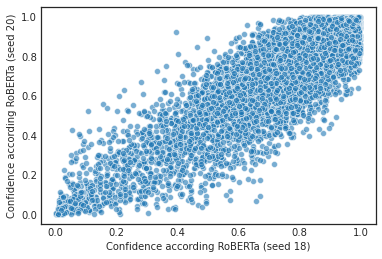

In [110]:
plt.figure()
fig, ax = plt.subplots()
df = merged_df.sample(n=25000)
dy = 'confidence'
sns.scatterplot(x=f'{dy}_x', y=f'{dy}_y', data=df, alpha=0.6)
ax.set_xlabel(f'{dy.capitalize()} according RoBERTa (seed 18)')
ax.set_ylabel(f'{dy.capitalize()} according RoBERTa (seed 20)')
df[f'{dy}_x'].corr(df[f'{dy}_y'])

0.6795412081968604

<Figure size 432x288 with 0 Axes>

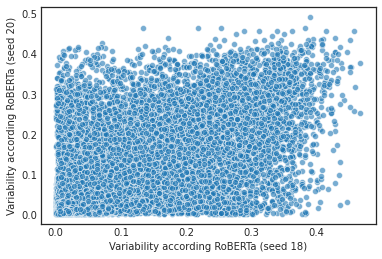

In [111]:
plt.figure()
fig, ax = plt.subplots()
dy = 'variability'
sns.scatterplot(x=f'{dy}_x', y=f'{dy}_y', data=df, alpha=0.6)
ax.set_xlabel(f'{dy.capitalize()} according RoBERTa (seed 18)')
ax.set_ylabel(f'{dy.capitalize()} according RoBERTa (seed 20)')
df[f'{dy}_x'].corr(df[f'{dy}_y'])

## what do high variability examples look like?

In [118]:
guids = list(train_dy_metrics.loc[train_dy_metrics['correctness'] == 3]['guid'])

In [121]:
correctness_pattern = defaultdict(int)

for guid in guids:
    record = training_dynamics[guid]
    label = record['gold']
    pattern = []
    for i, epoch_logits in enumerate(record['logits']):
        pred = np.argmax(epoch_logits)
        pattern.append(pred == label)
    
    correctness_pattern[str(pattern)] += 1

In [122]:
correctness_pattern

defaultdict(int,
            {'[False, False, True, True, True]': 7552,
             '[False, True, True, True, False]': 623,
             '[False, True, False, True, True]': 2561,
             '[True, False, False, True, True]': 1082,
             '[False, True, True, False, True]': 1189,
             '[True, True, False, False, True]': 284,
             '[True, False, True, False, True]': 522,
             '[True, True, True, False, False]': 128,
             '[True, False, True, True, False]': 307,
             '[True, True, False, True, False]': 201})

## random exploration

In [14]:
model_dir = HOME_DIR / 'output/mnli_random_al'
train_dy_filename = os.path.join(model_dir, "test_td_metrics.jsonl")
train_dy_metrics = pd.read_json(train_dy_filename, lines=True)

In [15]:
train_dy_metrics['variability'].corr(train_dy_metrics['mean_variability'])

0.9726678578147743

In [16]:
train_dy_metrics

,guid,index,threshold_closeness,confidence,variability,mean_variability,correctness,forgetfulness
0,1963513,0,0.044787,0.953005,0.027894,0.018596,2,0
1,1963523,1,0.001611,0.998386,0.000761,0.000507,2,0
2,1963533,2,0.021241,0.978287,0.005340,0.003560,2,0
3,1963543,3,0.074733,0.918649,0.015426,0.010284,2,0
4,1963553,4,0.016414,0.983307,0.001794,0.001333,2,0
...,...,...,...,...,...,...,...,...
39264,2356153,39264,0.212848,0.307253,0.033654,0.022527,0,1000
39265,2356163,39265,0.025077,0.974260,0.004458,0.002972,2,0
39266,2356173,39266,0.100480,0.886678,0.001764,0.004801,2,0
39267,2356183,39267,0.005338,0.994633,0.002957,0.001971,2,0


In [13]:
train_dy_metrics['mean_variability'].median()

0.0024018293

In [17]:
train_dy_metrics['mean_variability'].median()

0.0024018293

In [24]:
model_dir = HOME_DIR / 'output/mnli'
df = pd.read_json(model_dir / 'test_dynamics/dynamics_epoch_None.jsonl', lines=True)
label_orders = list(itertools.permutations([0,1,2]))
for label_order in label_orders:
    swap = {l: label_order[l] for l in [0,1,2]}
    print(swap)
    correct = 0

    for i, row in df.iterrows():
        label = np.argmax(row['logits_epoch_None'])
        label = swap[label]
        if label == row['gold']:
            correct += 1

    print(correct/len(df.index))

{0: 0, 1: 1, 2: 2}
0.26902173913043476
{0: 0, 1: 2, 2: 1}
0.27898550724637683
{0: 1, 1: 0, 2: 2}
0.31521739130434784
{0: 1, 1: 2, 2: 0}
0.36141304347826086
{0: 2, 1: 0, 2: 1}
0.3695652173913043
{0: 2, 1: 1, 2: 0}
0.4057971014492754


In [9]:
df

,guid,logits_epoch_None,gold
0,3,"[0.7201202512, 0.6620017886, -0.8804603219]",0
1,13,"[0.3093428314, 0.5927125216, -0.5719681978]",0
2,23,"[0.2418702841, 0.34659036990000003, -0.3982632...",1
3,33,"[0.1642865092, 0.3734895587, -0.375613898]",1
4,43,"[-0.0242729746, 1.6935517788, -1.1614971161]",0
...,...,...,...
1099,10993,"[0.6065279841, 0.4188045561, -0.664139092]",2
1100,11003,"[-0.5695004463000001, 1.2161358595, -0.5071014...",0
1101,11013,"[-1.0812550783, 1.2347205877, -0.2302316725]",0
1102,11023,"[-0.2849182785, 0.9618169665, -0.5130916834]",2
